In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
%matplotlib inline

pd.set_option('display.max_rows', 50)  # показывать больше строк
pd.set_option('display.max_columns', 50)  # показывать больше колонок

plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Загружаем набор
stud = pd.read_csv('stud_math.xls')
stud.head(10)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


In [3]:
# Теперь можно на него посмотреть
stud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

In [4]:
# Целевая переменная содержит пропуски - эти строки можно удалить
stud.dropna(subset=['score'], inplace=True)
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               389 non-null    object 
 1   sex                  389 non-null    object 
 2   age                  389 non-null    int64  
 3   address              374 non-null    object 
 4   famsize              362 non-null    object 
 5   Pstatus              344 non-null    object 
 6   Medu                 386 non-null    float64
 7   Fedu                 365 non-null    float64
 8   Mjob                 370 non-null    object 
 9   Fjob                 353 non-null    object 
 10  reason               372 non-null    object 
 11  guardian             358 non-null    object 
 12  traveltime           361 non-null    float64
 13  studytime            382 non-null    float64
 14  failures             367 non-null    float64
 15  schoolsup            380 non-null    obj

In [5]:
# В задании не описан столбец 'studytime, granular' посмотрим на его корелляцию с другими признаками
stud.corr()['studytime, granular']

age                    0.018227
Medu                  -0.081032
Fedu                  -0.059618
traveltime             0.105910
studytime             -1.000000
failures               0.181947
studytime, granular    1.000000
famrel                -0.046249
freetime               0.125066
goout                  0.053831
health                 0.079180
absences               0.025707
score                 -0.115741
Name: studytime, granular, dtype: float64

In [6]:
# Видим, что признак 'studytime, granular' отрицательно коррелирован с 'studytime' - удаляем его
stud.drop('studytime, granular', axis=1, inplace=True)
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   Pstatus     344 non-null    object 
 6   Medu        386 non-null    float64
 7   Fedu        365 non-null    float64
 8   Mjob        370 non-null    object 
 9   Fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   382 non-null    float64
 14  failures    367 non-null    float64
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

In [7]:
# Из всех признаков числовыми я бы назвал только age, absences, score
# остальне номинативные
num_features = ['age', 'absences', 'score']
nom_features = list(set(stud.columns) - set(num_features))

## Исследование числовых признаков

In [8]:
def describe(feature):
    display(stud[feature].describe())
    print(f'Количество пропусков: {stud[feature].isna().sum()}')
    print(
        f'Процент пропусков: {round((stud[feature].isna().sum() / len(stud[feature])) * 100, 2)}%')


def outliers(feature):
    # Интерквартильный размах
    perc25 = stud[feature].quantile(0.25)
    perc75 = stud[feature].quantile(0.75)
    IQR = perc75 - perc25
    low, high = (perc25 - 1.5 * IQR, perc75 + 1.5 * IQR)
    print(
        f'25-й перцентиль: {perc25}, 75-й перцентиль: {perc75}, IQR: {IQR}, Границы выбросов: [{low}, {high}]')
    return stud[(stud[feature] < low) | (stud[feature] > high)]


def hist(feature):
    fig, ax = plt.subplots()
    #  Добавляем подписи к осям:
    ax.set_xlabel(feature)
    ax.set_ylabel('count')
    ax.set_title(f'Гистограмма распределения признака {feature}')
    _ = stud[feature].hist(bins=stud[feature].nunique() * 2)


def boxplot(feature):
    fig, ax = plt.subplots()
    ax.set_title(f'Boxplot признака {feature}')
    _ = sns.boxplot(x=stud[feature], ax=ax)

### score — баллы по госэкзамену по математике

count    389.000000
mean      52.262211
std       22.919022
min        0.000000
25%       40.000000
50%       55.000000
75%       70.000000
max      100.000000
Name: score, dtype: float64

Количество пропусков: 0
Процент пропусков: 0.0%
25-й перцентиль: 40.0, 75-й перцентиль: 70.0, IQR: 30.0, Границы выбросов: [-5.0, 115.0]
Выбросы не обнаружены


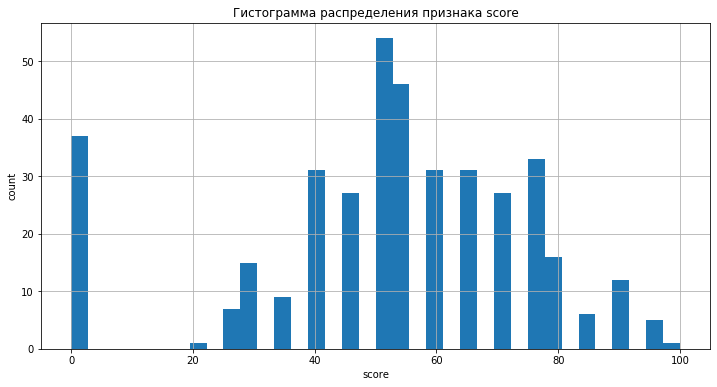

In [9]:
describe('score')
hist('score')

out_df = outliers('score')
if not out_df.empty:
    print('Обнаружены выбросы:')
    display(out_df)
else:
    print('Выбросы не обнаружены')

In [10]:
# Очень много значений score = 0
print(f'Количество score равных 0: {len(stud[stud["score"] == 0])}')
print(
    f'Процент score равных 0: {round(len(stud[stud["score"] == 0]) * 100 / len(stud), 2)}')
stud[stud["score"] == 0]

Количество score равных 0: 37
Процент score равных 0: 9.51


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
128,GP,M,18,R,NaN,T,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,no,yes,no,yes,yes,yes,yes,no,3.0,3.0,3.0,4.0,0.0,0.0
130,GP,F,15,R,GT3,T,3.0,4.0,services,teacher,course,father,2.0,3.0,2.0,no,yes,no,no,yes,yes,yes,yes,4.0,2.0,2.0,5.0,0.0,0.0
131,GP,F,15,U,GT3,NaN,1.0,1.0,at_home,other,course,mother,3.0,1.0,0.0,no,yes,no,yes,no,yes,yes,yes,4.0,NaN,3.0,4.0,0.0,0.0
134,GP,M,15,R,GT3,T,3.0,4.0,at_home,teacher,course,mother,NaN,2.0,0.0,no,yes,no,no,yes,yes,no,yes,5.0,3.0,3.0,5.0,0.0,0.0
135,GP,F,15,U,GT3,T,4.0,4.0,services,NaN,course,mother,1.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,yes,4.0,3.0,3.0,5.0,0.0,0.0
136,GP,M,17,R,GT3,T,3.0,4.0,at_home,other,course,mother,3.0,2.0,0.0,no,no,NaN,no,yes,yes,no,no,NaN,4.0,5.0,5.0,0.0,0.0
137,GP,F,16,U,GT3,A,3.0,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
140,GP,M,15,U,GT3,T,4.0,3.0,teacher,services,NaN,father,2.0,4.0,0.0,yes,yes,no,NaN,yes,yes,yes,no,2.0,2.0,2.0,3.0,0.0,0.0
144,GP,M,17,U,GT3,T,2.0,1.0,other,other,home,NaN,1.0,1.0,3.0,no,yes,no,no,yes,yes,yes,no,5.0,4.0,5.0,5.0,0.0,0.0
146,GP,F,15,U,GT3,T,3.0,2.0,health,services,home,father,1.0,2.0,3.0,no,NaN,no,no,yes,yes,yes,no,3.0,3.0,2.0,3.0,0.0,0.0


In [11]:
# Такой большой процент, при условии что нет студентов с результатом меньше 20 баллов не равных 0, говорит, скорее всего, о том,
# что при результате экзамена меньше 20 баллов ставится 0.  Если это так, то предполагаю 4 возможных сценария обработки этих данных
# 1 - оставить все как есть
# 2 - удалить эти данные из рассмотрения
# 3 - заполнить параметр score равномерно из диапазона 0 - 15 с шагом 5
# 4 - заполнить параметр score как нормально распределенные величины из диапазона 0 - 15  с шагом 5
# Самый "интересный" вариант последний - попробуем его
import scipy.stats as stat
stud = stud.copy()
q25 = stat.norm.ppf(0.25, loc=0, scale=1)
q50 = stat.norm.ppf(0.50, loc=0, scale=1)
q75 = stat.norm.ppf(0.75, loc=0, scale=1)
# Фиксируем генерируемую последовательность
np.random.seed(42)
val = list(map(lambda x: 0 if x < q25 else 5 if x < q50 else 10 if x <
               q75 else 15, np.random.normal(loc=0, scale=1, size=len(stud[stud["score"] < 20]))))
i = 0
for idx, row in stud[stud["score"] < 20].iterrows():
    stud.at[idx, 'score'] = val[i]
    i += 1

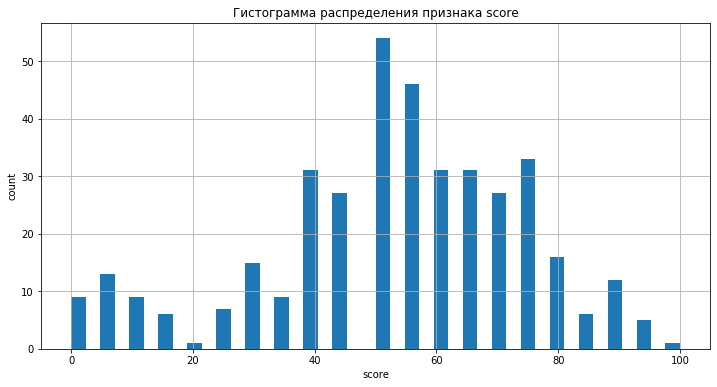

In [12]:
hist('score')

### absences — количество пропущенных занятий

count    378.000000
mean       7.320106
std       23.615525
min        0.000000
25%        0.000000
50%        4.000000
75%        8.000000
max      385.000000
Name: absences, dtype: float64

Количество пропусков: 11
Процент пропусков: 2.83%
25-й перцентиль: 0.0, 75-й перцентиль: 8.0, IQR: 8.0, Границы выбросов: [-12.0, 20.0]
Обнаружены выбросы (17):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
260,GP,F,18,U,GT3,NaN,4.0,3.0,NaN,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,yes,yes,yes,3.0,1.0,2.0,2.0,21.0,90.0
313,GP,F,19,U,NaN,NaN,3.0,2.0,services,other,reputation,other,2.0,2.0,NaN,no,NaN,NaN,no,no,yes,yes,yes,4.0,2.0,2.0,1.0,22.0,55.0
277,GP,M,18,U,GT3,T,4.0,4.0,NaN,services,home,mother,2.0,1.0,0.0,no,no,yes,yes,yes,yes,yes,no,3.0,2.0,4.0,3.0,22.0,45.0
216,GP,F,17,U,GT3,T,4.0,3.0,other,NaN,reputation,mother,1.0,2.0,2.0,no,no,yes,no,yes,yes,yes,yes,3.0,4.0,5.0,1.0,22.0,20.0
320,GP,F,17,U,GT3,A,4.0,3.0,services,services,course,mother,1.0,2.0,NaN,no,yes,yes,no,yes,NaN,yes,yes,5.0,2.0,2.0,5.0,23.0,65.0
198,GP,F,17,U,GT3,NaN,4.0,4.0,services,teacher,home,mother,2.0,1.0,1.0,no,yes,no,no,yes,yes,NaN,no,4.0,2.0,4.0,2.0,24.0,90.0
40,GP,F,16,U,LE3,T,2.0,2.0,other,other,home,mother,2.0,2.0,1.0,no,NaN,no,yes,no,yes,yes,yes,3.0,3.0,3.0,3.0,25.0,55.0
103,GP,F,15,U,GT3,T,3.0,2.0,services,other,home,mother,2.0,2.0,0.0,yes,yes,yes,no,yes,yes,yes,no,4.0,3.0,5.0,2.0,26.0,30.0
205,GP,F,17,U,GT3,T,3.0,4.0,at_home,services,home,mother,1.0,3.0,1.0,no,yes,yes,no,yes,yes,yes,yes,4.0,4.0,3.0,5.0,28.0,45.0
280,GP,M,17,U,NaN,A,4.0,NaN,services,other,home,mother,2.0,1.0,NaN,no,no,yes,yes,yes,yes,yes,NaN,4.0,NaN,4.0,5.0,30.0,40.0


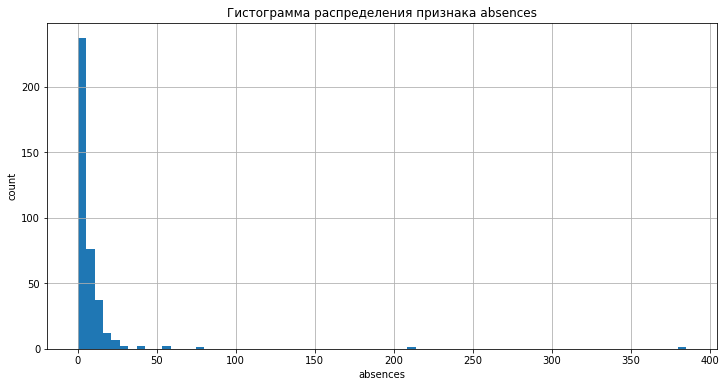

In [13]:
describe('absences')
hist('absences')
out_df = outliers('absences')
if not out_df.empty:
    print(f'Обнаружены выбросы ({len(out_df)}):')
    display(out_df.sort_values('absences'))
else:
    print('Выбросы не обнаружены')

In [14]:
# Пропуски, в данном случае, можно заполнить медианным значением
stud['absences'].fillna(stud['absences'].median(), inplace=True)

In [15]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   Pstatus     344 non-null    object 
 6   Medu        386 non-null    float64
 7   Fedu        365 non-null    float64
 8   Mjob        370 non-null    object 
 9   Fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   382 non-null    float64
 14  failures    367 non-null    float64
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

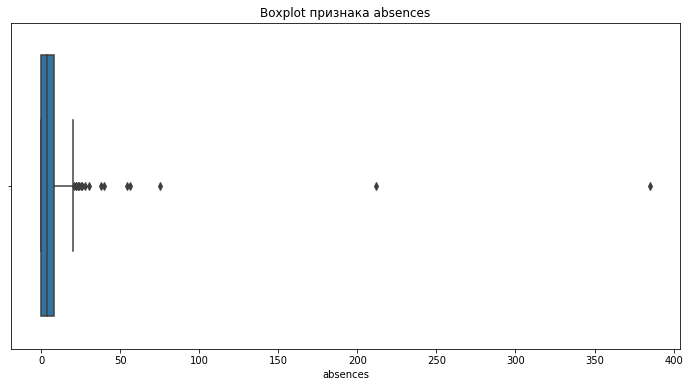

In [16]:
boxplot('absences')

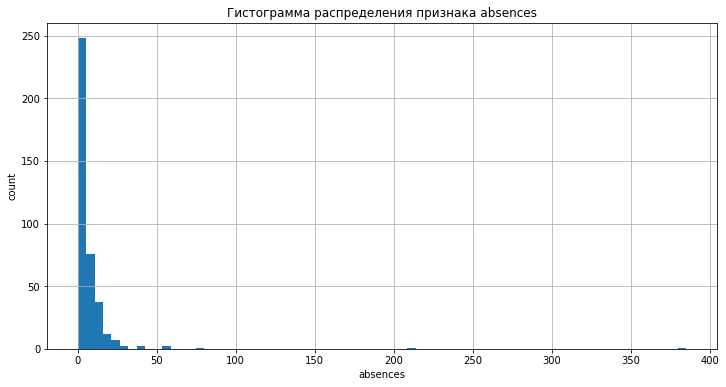

In [17]:
# Формула интерквартильного расстояния дает слишком много выбросов
# Подозрение вызывают только записи, где absences >= 30.
# С другой стороны эти студенты получили достаточно низкие баллы,
# а у студента с количеством пропусков 385 отец учитель и он мог находиться на домашнем обучении
#stud = stud[stud['absences'].between(0, 30)]
hist('absences')

In [18]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   Pstatus     344 non-null    object 
 6   Medu        386 non-null    float64
 7   Fedu        365 non-null    float64
 8   Mjob        370 non-null    object 
 9   Fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   382 non-null    float64
 14  failures    367 non-null    float64
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

### age — возраст ученика (от 15 до 22)

count    389.000000
mean      16.673522
std        1.265662
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64

Количество пропусков: 0
Процент пропусков: 0.0%
25-й перцентиль: 16.0, 75-й перцентиль: 18.0, IQR: 2.0, Границы выбросов: [13.0, 21.0]
Обнаружены выбросы (1):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
247,GP,M,22,U,GT3,T,3.0,1.0,services,services,other,mother,1.0,1.0,3.0,no,no,no,no,no,no,yes,yes,5.0,4.0,5.0,1.0,16.0,40.0


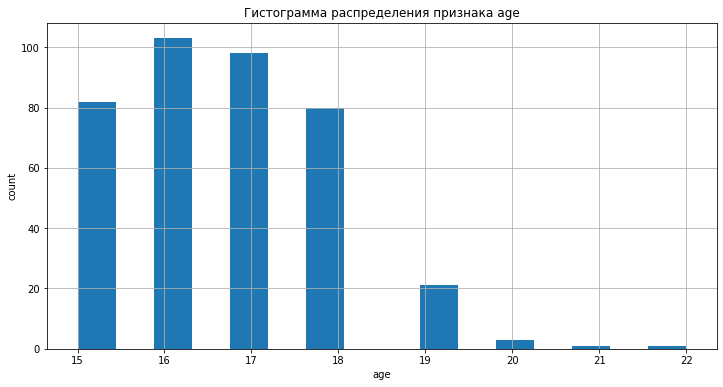

In [19]:
describe('age')
hist('age')
out_df = outliers('age')
if not out_df.empty:
    print(f'Обнаружены выбросы ({len(out_df)}):')
    display(out_df.sort_values('age'))
else:
    print('Выбросы не обнаружены')

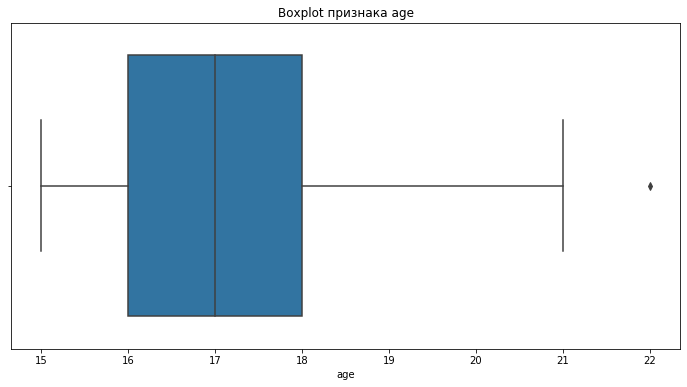

In [20]:
boxplot('age')

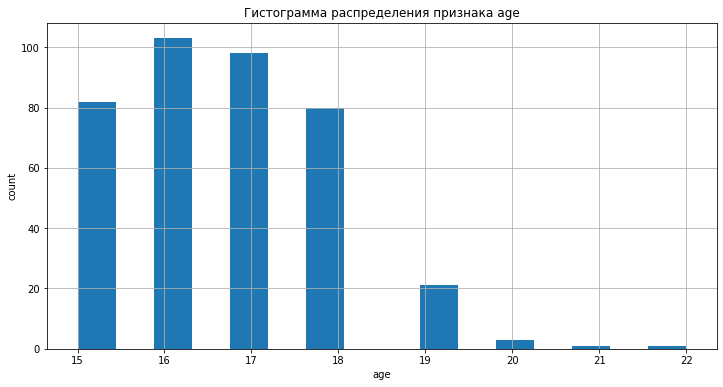

In [21]:
# Студенты старше 21 года определяются как выбросы, но в задании указан интервал от 15 до 22 лет,
# поэтому оставляем
#stud = stud[stud['age'].between(0, 21)]
hist('age')

In [22]:
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      389 non-null    object 
 1   sex         389 non-null    object 
 2   age         389 non-null    int64  
 3   address     374 non-null    object 
 4   famsize     362 non-null    object 
 5   Pstatus     344 non-null    object 
 6   Medu        386 non-null    float64
 7   Fedu        365 non-null    float64
 8   Mjob        370 non-null    object 
 9   Fjob        353 non-null    object 
 10  reason      372 non-null    object 
 11  guardian    358 non-null    object 
 12  traveltime  361 non-null    float64
 13  studytime   382 non-null    float64
 14  failures    367 non-null    float64
 15  schoolsup   380 non-null    object 
 16  famsup      351 non-null    object 
 17  paid        350 non-null    object 
 18  activities  375 non-null    object 
 19  nursery     374 non-null    o

## Исследование категориальных признаков

In [23]:
def countplot(feature):
    fig, ax = plt.subplots()
    #  Добавляем подписи к осям:
    ax.set_xlabel(feature)
    ax.set_ylabel('count')
    ax.set_title(f'Кол-во значений признака {feature}')
    sns.set_style('whitegrid')
    _ = sns.countplot(x=feature, data=stud.fillna('NaN'), ax=ax)


def display_nan_rows(feature):
    df_nan = stud[stud[feature].isna()]
    if not df_nan.empty:
        print(f'Строки с пропусками {feature}:')
        display(df_nan.style.applymap(
            lambda x: 'color: red' if pd.isnull(x) else 'color: black'))
#    df_nan.style.applymap(lambda x: print(x))
#    display(df_nan)

In [24]:
# Преобразуем номинативные признаки в тип category
stud[nom_features] = stud[nom_features].astype('category')
stud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 394
Data columns (total 29 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   school      389 non-null    category
 1   sex         389 non-null    category
 2   age         389 non-null    int64   
 3   address     374 non-null    category
 4   famsize     362 non-null    category
 5   Pstatus     344 non-null    category
 6   Medu        386 non-null    category
 7   Fedu        365 non-null    category
 8   Mjob        370 non-null    category
 9   Fjob        353 non-null    category
 10  reason      372 non-null    category
 11  guardian    358 non-null    category
 12  traveltime  361 non-null    category
 13  studytime   382 non-null    category
 14  failures    367 non-null    category
 15  schoolsup   380 non-null    category
 16  famsup      351 non-null    category
 17  paid        350 non-null    category
 18  activities  375 non-null    category
 19  nursery 

In [25]:
# Теперь возможные значения
for feature in nom_features:
    print(f'Уникальные значения признака {feature}:', np.sort(stud[feature].unique().categories.values))

Уникальные значения признака activities: ['no' 'yes']
Уникальные значения признака paid: ['no' 'yes']
Уникальные значения признака famsize: ['GT3' 'LE3']
Уникальные значения признака Pstatus: ['A' 'T']
Уникальные значения признака internet: ['no' 'yes']
Уникальные значения признака school: ['GP' 'MS']
Уникальные значения признака romantic: ['no' 'yes']
Уникальные значения признака Mjob: ['at_home' 'health' 'other' 'services' 'teacher']
Уникальные значения признака higher: ['no' 'yes']
Уникальные значения признака freetime: [1. 2. 3. 4. 5.]
Уникальные значения признака sex: ['F' 'M']
Уникальные значения признака studytime: [1. 2. 3. 4.]
Уникальные значения признака Fedu: [ 0.  1.  2.  3.  4. 40.]
Уникальные значения признака failures: [0. 1. 2. 3.]
Уникальные значения признака traveltime: [1. 2. 3. 4.]
Уникальные значения признака nursery: ['no' 'yes']
Уникальные значения признака schoolsup: ['no' 'yes']
Уникальные значения признака guardian: ['father' 'mother' 'other']
Уникальные значе

In [26]:
# Для удобства рассмотрения предлагаю разделить категориальные признаки на 3 группы
# 1 - принимающие 2 значения (бинарные)
# 2 - те, что имеют отношения порядка (порядковые) 
# 3 - где нет отношения порядка (категориальные)
bin_features = ['nursery', 'Pstatus', 'schoolsup', 'higher', 'paid', 'famsup', 
                'romantic', 'address', 'sex', 'activities', 'school', 'famsize']
cat_features = ['guardian', 'Fjob', 'Mjob', 'reason']
ord_features = ['health', 'famrel', 'studytime', 'traveltime',
                'Fedu', 'Medu', 'freetime', 'failures', 'goout']

 ###  Бинарные признаки

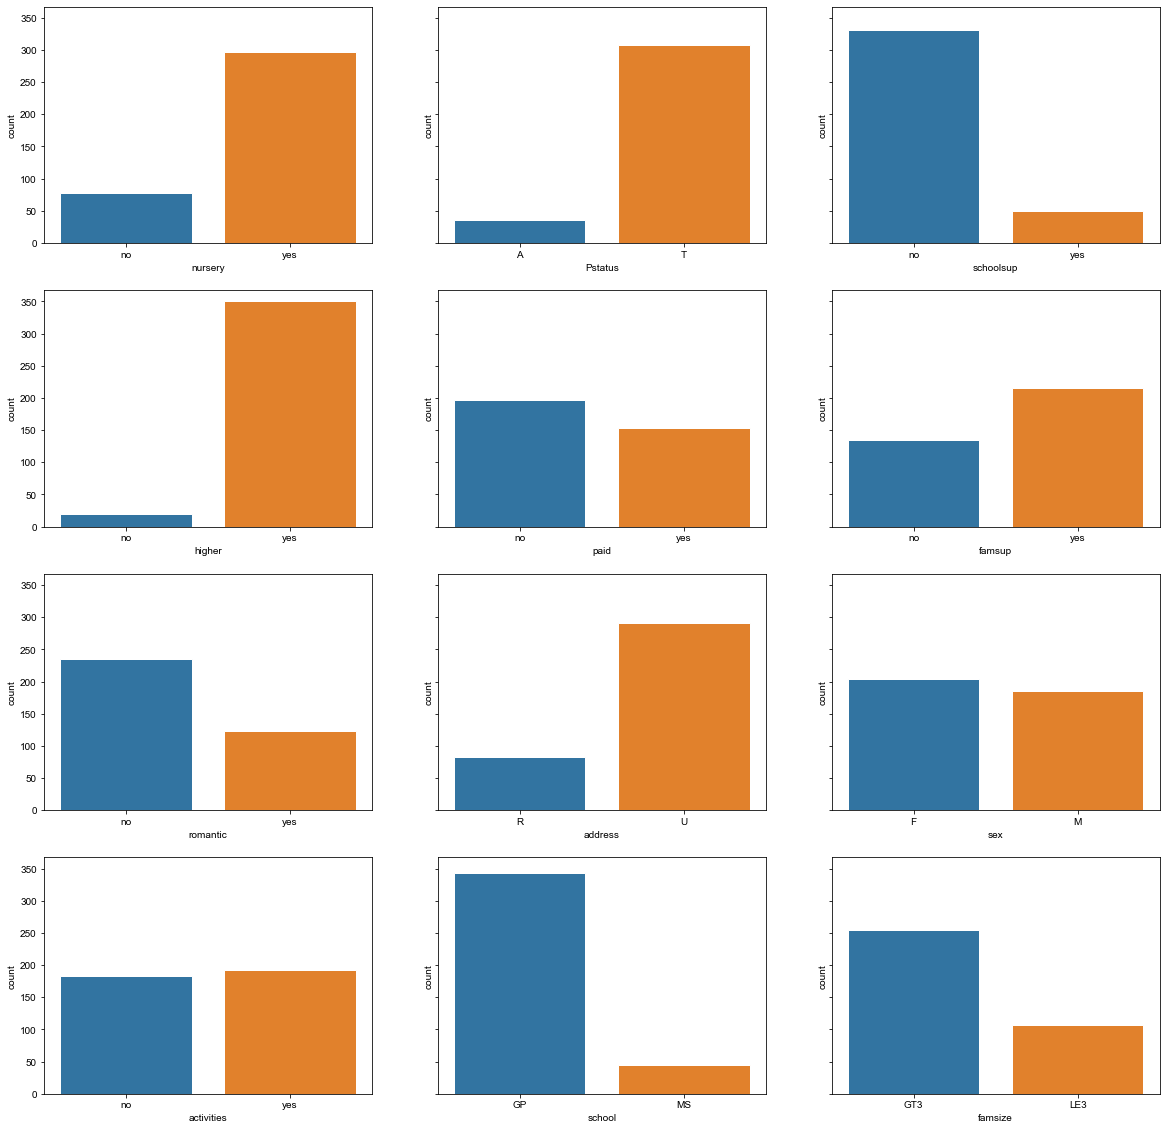

In [27]:
# Ищем выбросы
fig, axes = plt.subplots(int(np.ceil(len(bin_features) / 3)), 3, figsize=(20, 20), sharey=True)
for i in range(len(bin_features)):
    sns.set_style('whitegrid')
    sns.countplot(x=bin_features[i], data=stud, ax=axes[int(i / 3), i % 3])

In [28]:
# Все признаки принимаю 2 значения (можно потом закодировать 0 и 1). Выбросов нет.
# Имеется сильная несбалансированность по некоторым из них (higher, Pstatus, school), но пока рано делать какие-то выводы

In [29]:
# Посмотрим на количество пропусков в этих столбцах
for feature in bin_features:
    nan_count = stud[feature].isna().sum()
    print(f'Количество пропусков в столбце {feature} - {nan_count} ({round(nan_count * 100 / len(stud), 2)}%)')

Количество пропусков в столбце nursery - 15 (3.86%)
Количество пропусков в столбце Pstatus - 45 (11.57%)
Количество пропусков в столбце schoolsup - 9 (2.31%)
Количество пропусков в столбце higher - 20 (5.14%)
Количество пропусков в столбце paid - 39 (10.03%)
Количество пропусков в столбце famsup - 38 (9.77%)
Количество пропусков в столбце romantic - 31 (7.97%)
Количество пропусков в столбце address - 15 (3.86%)
Количество пропусков в столбце sex - 0 (0.0%)
Количество пропусков в столбце activities - 14 (3.6%)
Количество пропусков в столбце school - 0 (0.0%)
Количество пропусков в столбце famsize - 27 (6.94%)


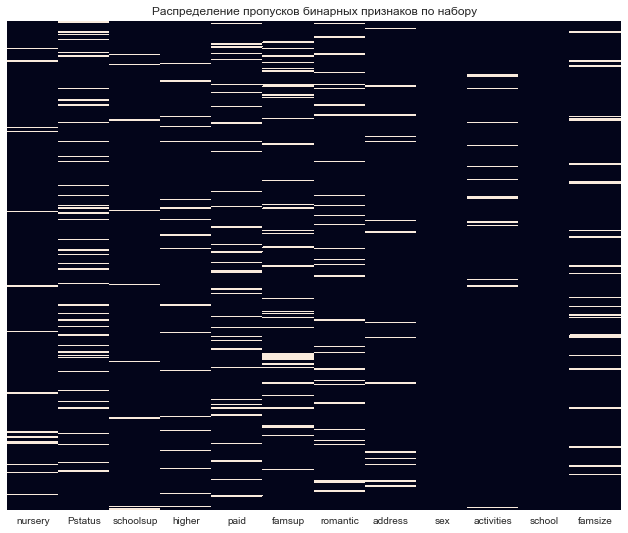

In [30]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Распределение пропусков бинарных признаков по набору')
_ = sns.heatmap(stud[bin_features].isnull(), cbar=False, ax=ax, yticklabels=False)

In [31]:
# Признаки содержат достаточно много пропусков.
# На этапе EDA пропуски можно оставить, но при построении модели, скорее всего, нужно будет удалить или заменить
# на значения, используя алгоритмы ML 

### Категориальные признаки

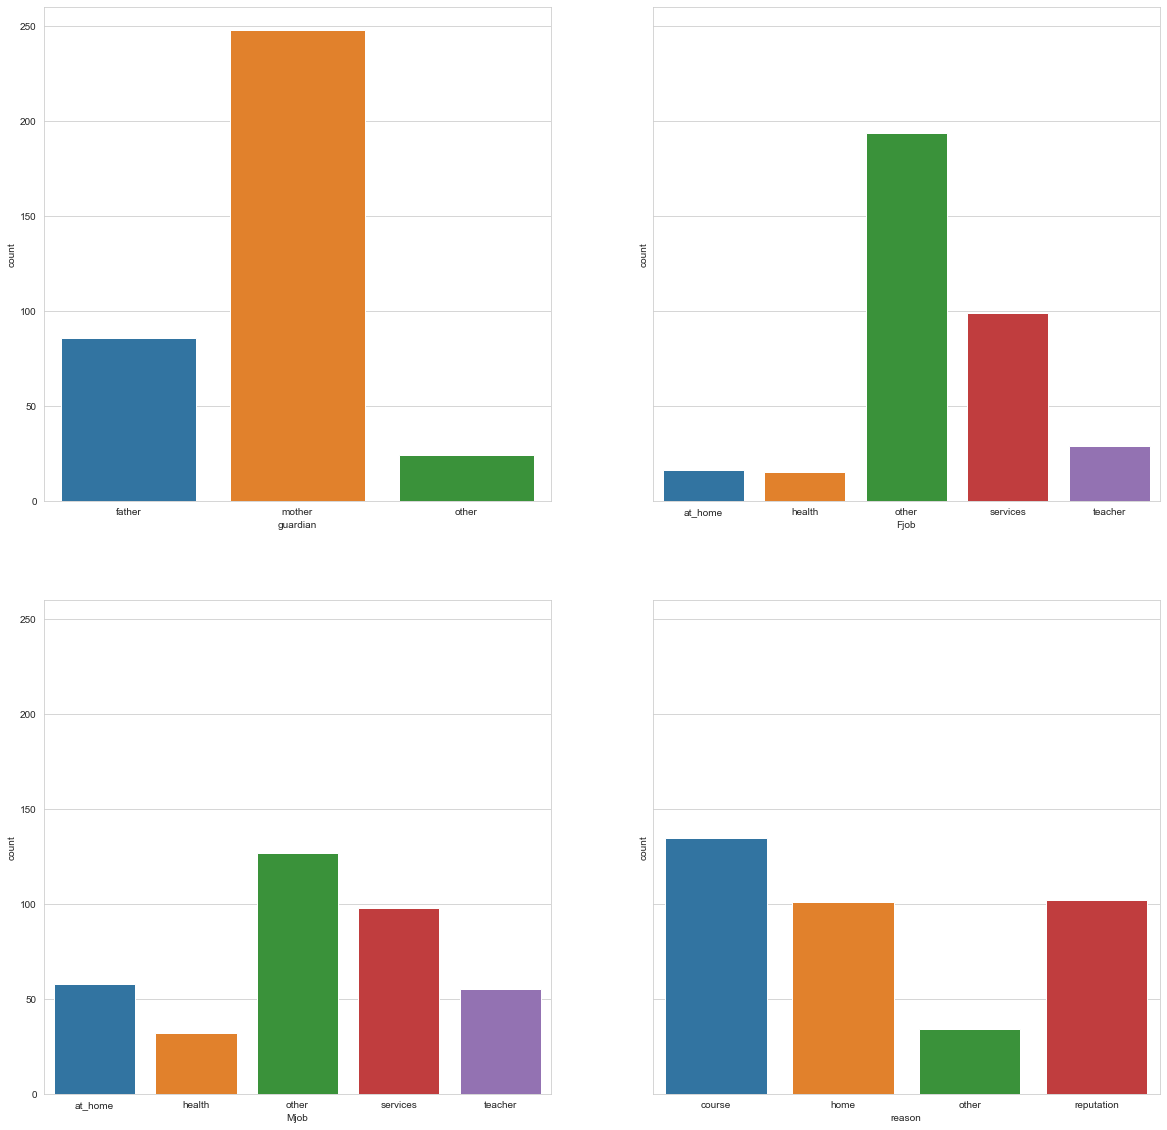

In [32]:
# Ищем выбросы
fig, axes = plt.subplots(int(np.ceil(len(cat_features) / 2)), 2, figsize=(20, 20), sharey=True)
for i in range(len(cat_features)):
    sns.set_style('whitegrid')
    sns.countplot(x=cat_features[i], data=stud, ax=axes[int(i / 2), i % 2])

In [33]:
# Все признаки принимают значения, соответствующие заданию. Выбросов нет. 
# Можно закодировать, например one-hot

In [34]:
# Посмотрим на количество пропусков в этих столбцах
for feature in cat_features:
    nan_count = stud[feature].isna().sum()
    print(f'Количество пропусков в столбце {feature} - {nan_count} ({round(nan_count * 100 / len(stud), 2)}%)')

Количество пропусков в столбце guardian - 31 (7.97%)
Количество пропусков в столбце Fjob - 36 (9.25%)
Количество пропусков в столбце Mjob - 19 (4.88%)
Количество пропусков в столбце reason - 17 (4.37%)


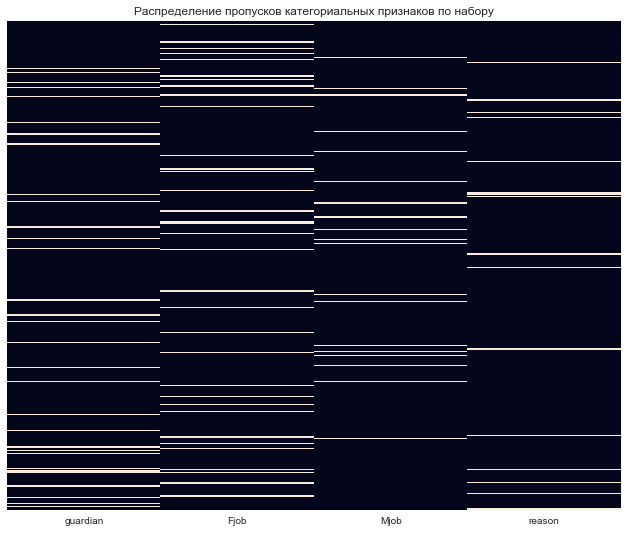

In [35]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Распределение пропусков категориальных признаков по набору')
_ = sns.heatmap(stud[cat_features].isnull(), cbar=False, ax=ax, yticklabels=False)

In [36]:
# Признаки содержат достаточно много пропусков.
# На этапе EDA пропуски можно оставить, но при построении модели, скорее всего, нужно будет удалить или заменить
# на значения, используя алгоритмы ML 

### Порядковые признаки

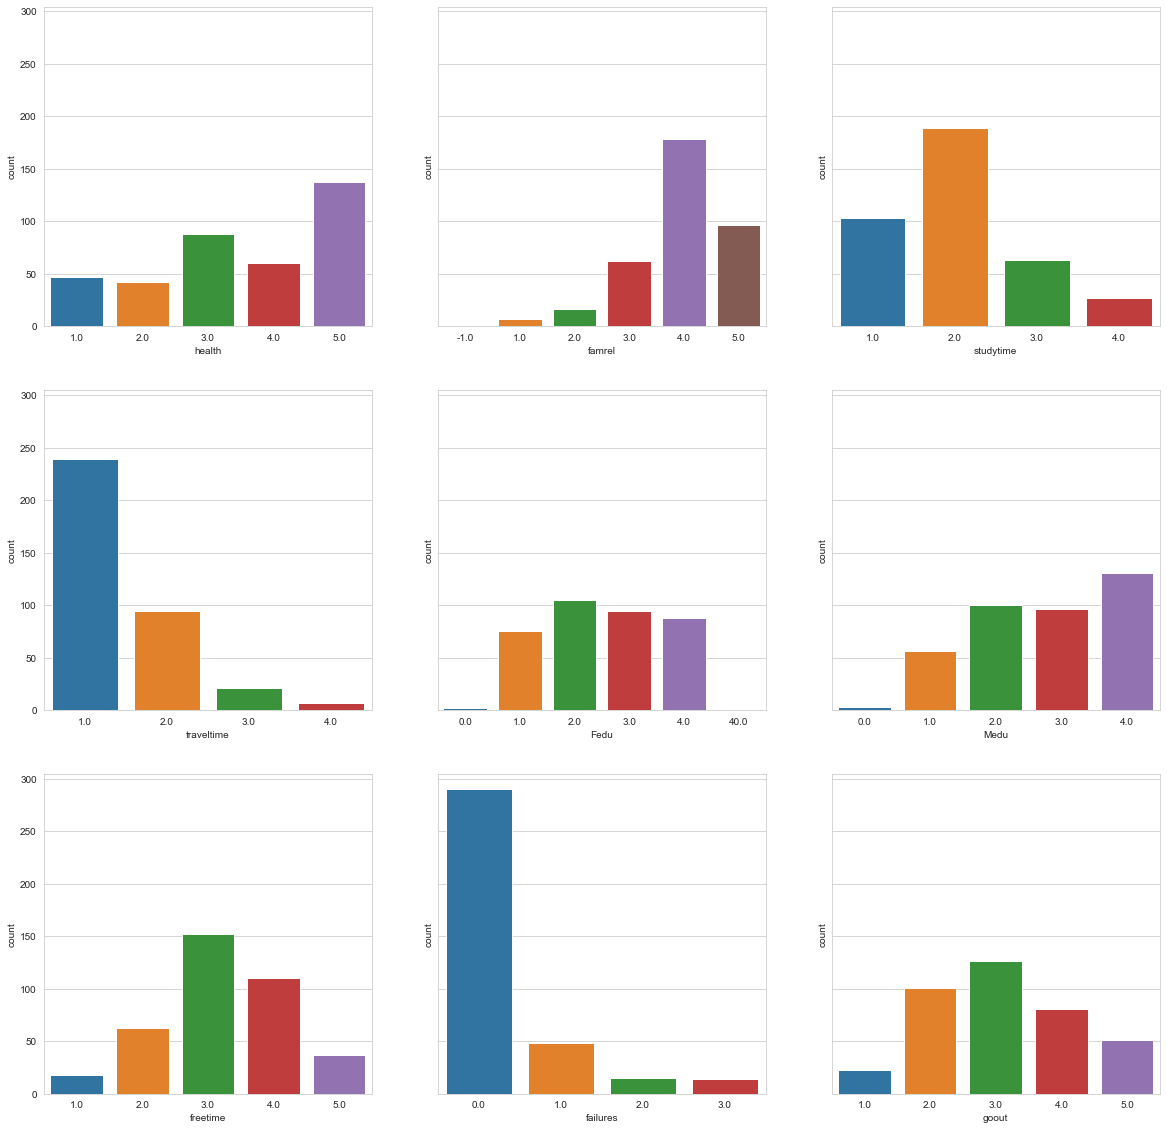

In [37]:
# Ищем выбросы
fig, axes = plt.subplots(int(np.ceil(len(ord_features) / 3)), 3, figsize=(20, 20), sharey=True)
for i in range(len(ord_features)):
    sns.set_style('whitegrid')
    sns.countplot(x=ord_features[i], data=stud, ax=axes[int(i / 3), i % 3])

In [38]:
# Видны значения, не соответствующие описанию признаков в задании. 
# В признаке famrel - значение -1
display(stud[stud['famrel'] == -1])
# В признаке Fedu - значение 40
display(stud[stud['Fedu'] == 40])

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
25,GP,F,16,U,GT3,NaN,2.0,2.0,services,services,home,mother,1.0,1.0,2.0,no,yes,yes,no,no,yes,yes,no,-1.0,2.0,2.0,5.0,14.0,40.0


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic,famrel,freetime,goout,health,absences,score
11,GP,F,15,U,GT3,NaN,2.0,40.0,services,other,reputation,father,3.0,3.0,0.0,no,yes,no,yes,yes,yes,yes,no,5.0,2.0,2.0,4.0,4.0,60.0


In [39]:
# Эти записи удаляем
stud = stud[stud['Fedu'] != 40]
stud = stud[stud['famrel'] != -1]

In [40]:
# Посмотрим на количество пропусков в этих столбцах
for feature in ord_features:
    nan_count = stud[feature].isna().sum()
    print(f'Количество пропусков в столбце {feature} - {nan_count} ({round(nan_count * 100 / len(stud), 2)}%)')

Количество пропусков в столбце health - 13 (3.83%)
Количество пропусков в столбце famrel - 0 (0.0%)
Количество пропусков в столбце studytime - 7 (2.06%)
Количество пропусков в столбце traveltime - 23 (6.78%)
Количество пропусков в столбце Fedu - 0 (0.0%)
Количество пропусков в столбце Medu - 3 (0.88%)
Количество пропусков в столбце freetime - 7 (2.06%)
Количество пропусков в столбце failures - 19 (5.6%)
Количество пропусков в столбце goout - 7 (2.06%)


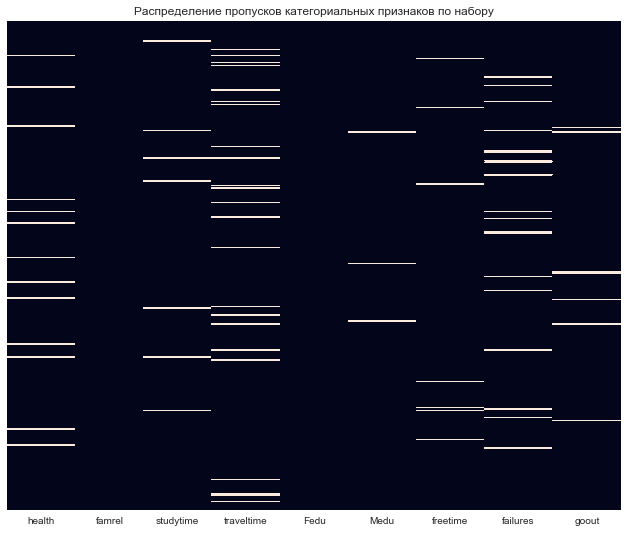

In [41]:
fig, ax = plt.subplots(figsize=(11, 9))
ax.set_title('Распределение пропусков порядковых признаков по набору')
_ = sns.heatmap(stud[ord_features].isnull(), cbar=False, ax=ax, yticklabels=False)

In [ ]:
# Признаки содержат отнсительно немного пропусков.
# На этапе EDA пропуски можно оставить, но при построении модели, скорее всего, нужно будет удалить или заменить
# на значения, используя алгоритмы ML 